## Ultimate Take home Challenge

Benhur Tedros

In [38]:
# Importing the required libraries

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import os
from datetime import datetime
import time
import json 
from pandas.io.json import json_normalize
from ggplot import *
import pylab
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from pandas.tools.plotting import scatter_matrix
from sklearn import preprocessing
import statsmodels.api as sm

In [39]:
# Checking my directory path
os.getcwd()

'C:\\Users\\benbahtin\\Data Science Career Track\\Springboard_takehome_Challenge'

In [40]:
# loading the json file as dataframe
logins = pd.read_json('logins.json')
ls = logins.set_index('login_time')
print(logins.head())
logins.info()

           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


### Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.


In [41]:
## Aggregate the counts of logins on 15-min time interval
ls['count'] =1
log_counts =ls.resample('15T').sum()
log_counts =log_counts.dropna(axis=0,how='any')
log_counts.head()

,count
login_time,
1970-01-01 20:00:00,2.0
1970-01-01 20:15:00,6.0
1970-01-01 20:30:00,9.0
1970-01-01 20:45:00,7.0
1970-01-01 21:00:00,1.0


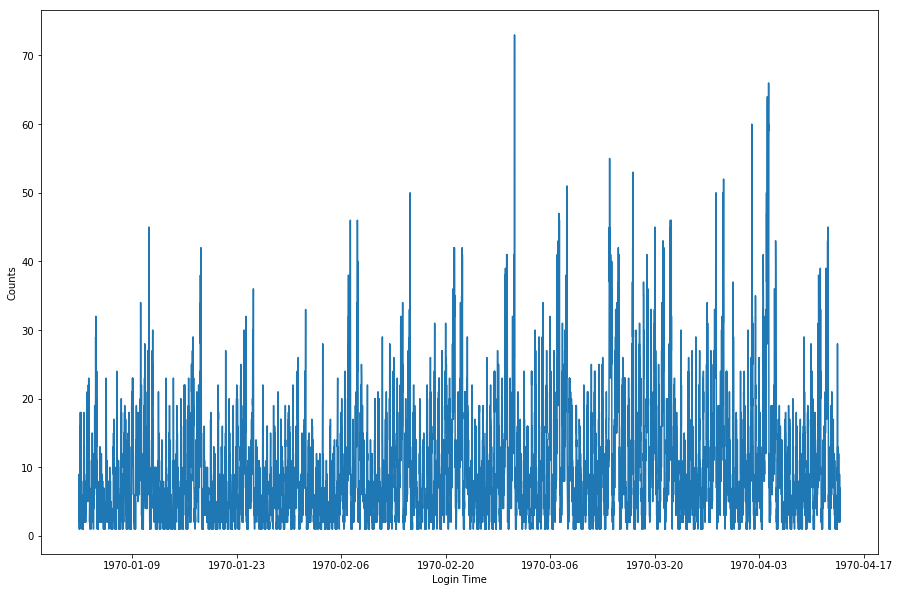

In [42]:
## Visualize the data
fig, ax =plt.subplots(figsize=(15,10))
plt.plot(log_counts)
ax.set_xlabel('Login Time')
ax.set_ylabel('Counts')

It can be observed from the above figure that there are variation/trend in the login counts across the given period of time. Let us analyze the daily to monthly cycles of the demands.

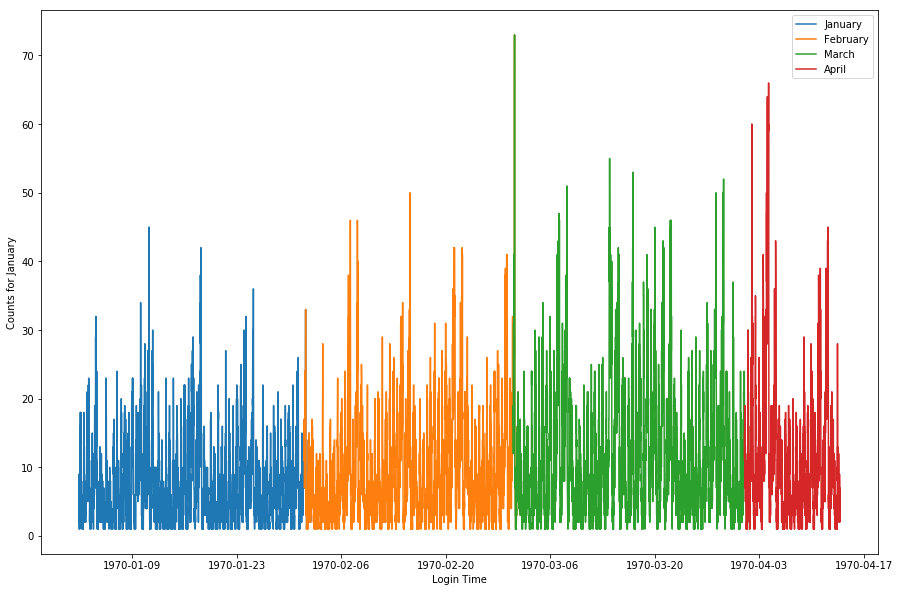

In [43]:
##Comparing the login counts among the months of January, February, March and April
fig, ax =plt.subplots(figsize=(15,10))

plt.plot(log_counts['1970-01-01':'1970-02-01'], label='January')
plt.plot(log_counts['1970-02-01':'1970-03-01'], label='February')
plt.plot(log_counts['1970-03-01':'1970-04-01'], label='March')
plt.plot(log_counts['1970-04-01':'1970-05-01'], label='April')
plt.legend()

ax.set_xlabel('Login Time')
ax.set_ylabel('Counts for January')

The daily cycle trends from the January and Febraury appeared to be similar, while the March and April trends looks different. However, let us explore what the daily logins looked like and how correlated they were.

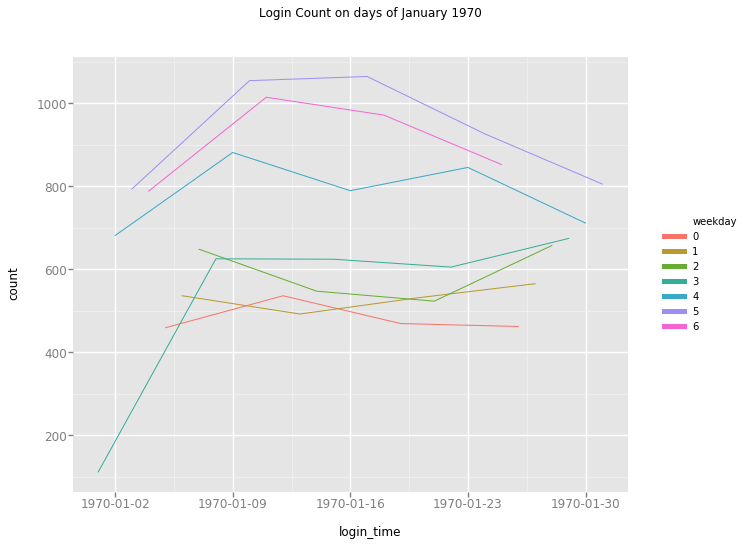

<ggplot: (56495822358)> 

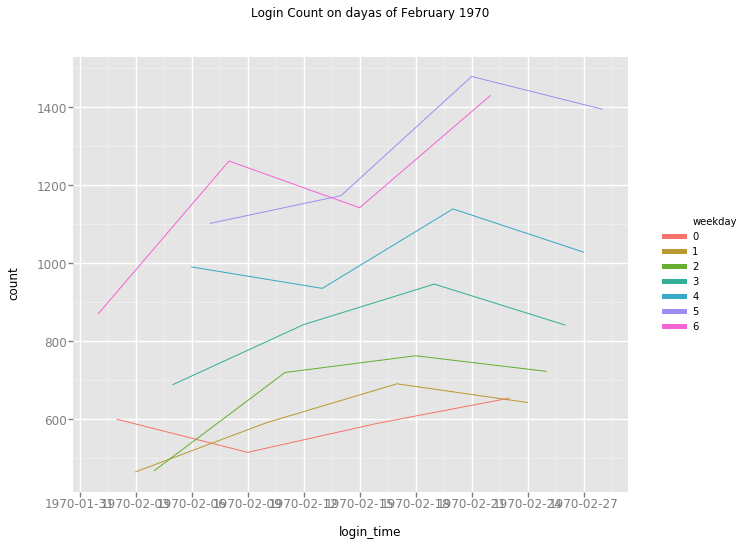

<ggplot: (-9223371980358948804)> 

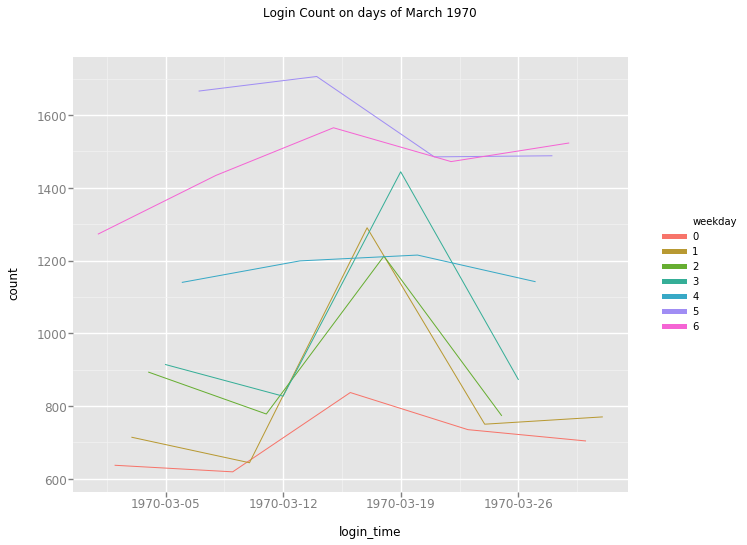

<ggplot: (-9223371980474683346)> 

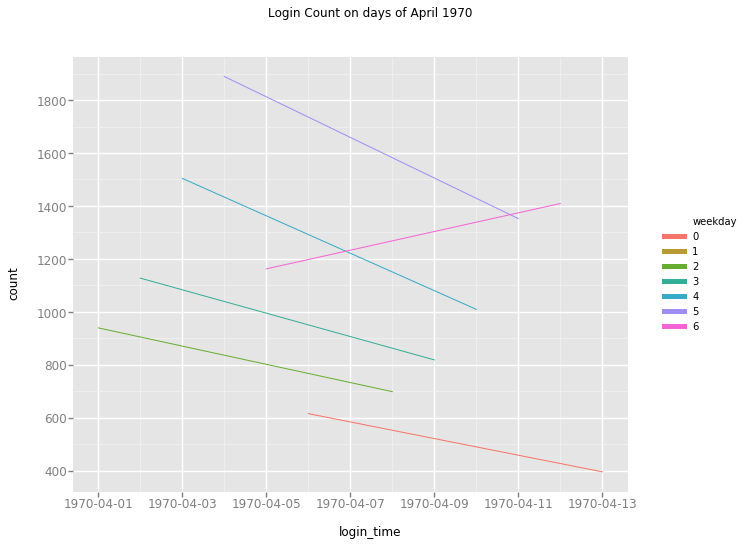

<ggplot: (-9223371980477021429)>


In [44]:
## Adding columns for the days of the week
mon = log_counts.resample('D').sum()
z = mon.reset_index()
z['weekday'] = z['login_time'].apply(lambda x: x.weekday())
z['weekday'] = z['weekday'].astype('str')
z['count'] = z['count'].astype('int')
z = z.set_index('login_time')

## Days of the week for January
jan_days = z['1970-01-01':'1970-01-31']
jan_days =jan_days.reset_index()

## Days of the week for February
feb_days = z['1970-02-01':'1970-02-28']
feb_days =feb_days.reset_index()

## Days of the week for March
mar_days = z['1970-03-01':'1970-03-31']
mar_days =mar_days.reset_index()

## Days of the week for April
apr_days = z['1970-04-01':'1970-04-30']
apr_days =apr_days.reset_index()

## Plotting the days of the week for January, February, March and April
j = ggplot(jan_days, aes(x ='login_time',y ='count',color='weekday')) + geom_line()  +  ggtitle("Login Count on days of January 1970")
f = ggplot(feb_days, aes(x ='login_time',y ='count',color='weekday')) + geom_line()  +  ggtitle("Login Count on dayas of February 1970") 
m = ggplot(mar_days, aes(x ='login_time',y ='count',color='weekday')) + geom_line()  +  ggtitle("Login Count on days of March 1970")
a = ggplot(apr_days, aes(x ='login_time',y ='count',color='weekday')) + geom_line()  +  ggtitle("Login Count on days of April 1970")

print(j,f,m,a)

The legend refers to Monday to Sunday. Based on the above figures, the highest demands were on weekends followed by Fridays. Also, the demands generally increased from January to April and towards the middle of the month except the month of April, which showed a decreasing trend. Since we don't have the full data of April, the conclusions for that month is partial. On the mid of March, the demands peaked up sharply during weekdays.  There might be some events happended in the cities which might have increased the demands [but it should be studied what made that peak to happen]. Pretty much, the demand was appeared to decrease towards the end of the month in each case except on the month of January. In all cases, Monday was with the lowest demands which is obvious.

## Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

The first key measure of success for this experiment would be a metric which measures the time spent by the drivers in each city. What percentage of their time did they spend in Gotham and Metropolis. For this experiment, we are encouraging the drivers to spend 50%-70% ( or 30%-50% )of this cumulative time to Gotham and the other  30%-50% (or 50%-70%) to the city of Metropolis.  As the activity during weekends and weekdays differs in both cities,  I would weigh the days differently in both cities.  Since the percentage of demands fluctuate from Gotham and Metropolis during a week, the 50% cumulative time should be measured as per week, not daily. For example, if a  driver spent 100% in Gotham and 0% in Metropolis this week, there should be given some incentives during peak hours to encourage the driver to spend more in Metropolis the next week. This will help to maintain the balance. 

The next step is how we can evaluate the effectiveness of the proposed change. The goal here is  to make drivers, whether he/she is from Gotham or Metropolis, split their weekly time in both cities equally (50% in Gotham and 50% in Metropolis). Let us choose the experiemental period that goes for two months of summer or early Spring, as the activity is slow in January and peaks at summer time. To measure the effective of the results, one-tailed z-test should be utilized.  The null hypothesis here states that there was no any changes on the time spent by the drivers. That means the drivers spend 100% of their time either in Gotham or Metropolis. The alternative hypothesis would be that the drivers spent less 100% of their average time either in Gotham or Metropolis.

Our results can be interpreted using p-value with 95% confidence interval. If we get a P-value less than 0.05, we can say the results are statistically significant. This means that we have 95% confidence that the average time spent driving in either cities was less than 100%.  My recommendation to the city operations along with possible caveats:

 <li> The experimental period should be implemented in different seasons, and the data from each season should be analyzed separateley
 <li> More incentives may also distrupt the balance in between the cities.
 <li> As the demands in both cities may differ and may not have equal proportion, splitting the driving time to both cities may not be profitable.


## Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

### Data description

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYY MM DD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

In [45]:
# Loading and reading the file
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)

ult = pd.DataFrame(data)

## Visualizing  the dataset
ult.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


### Exploring the Data variables

In [46]:
## Exploring the types of the data fields and null values in the dataset
ult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


As it can be observed above, the avg_rating_by_driver, avg_rating_of_driver and phone datafields have null values.  The null values could be replaced either by mean or median median, which can be determined by their distribution.  Let us make the barplot/density plot to explore their data. And the dates also are not to the required date format, and we should convert them to datetime format. 

In [47]:
## Convert to datetime format
ult['last_trip_date'] = pd.to_datetime(ult['last_trip_date'])
ult['signup_date'] = pd.to_datetime(ult['signup_date'] )

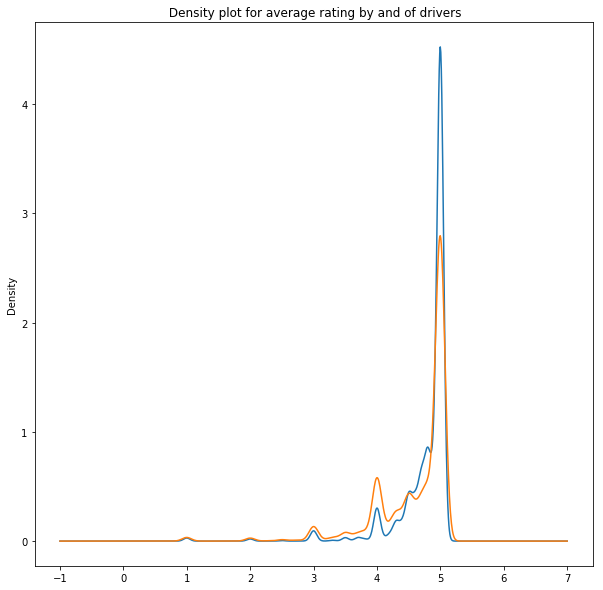

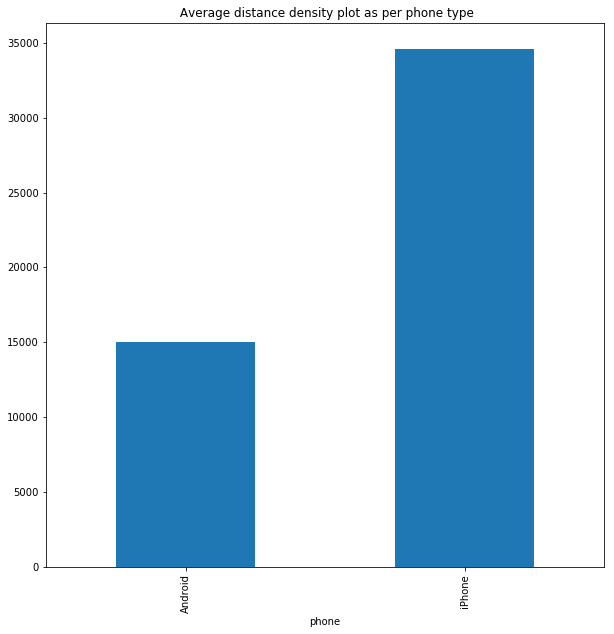

In [48]:
## Density plot for avg_rating_by_driver
fig, ax = plt.subplots(figsize=(10,10))
r = pd.Series(ult['avg_rating_by_driver'])
r.plot(kind='kde')

## Density plot for avg_rating_of_driver
d = pd.Series(ult['avg_rating_of_driver'])
d.plot(kind='kde')
ax.set_title(' Density plot for average rating by and of drivers')

plt.show()

## Density plot for phone
fig, ax = plt.subplots(figsize=(10,10))
pho =ult.groupby('phone')['avg_dist'].count()
pho.plot(kind='bar')
ax.set_title(' Average distance density plot as per phone type')

The density plots indicate that the data distribution for the rider's average rating of drivers and by drivers is appeared to be a left skewed distribution. Therefore, it is recommended to use median [instead of mean]. Regarding to the last figure, the iphone is more dominant which makes us to fill up the null values of this column with iphone.

In [49]:
# ## Let us get rid off the dates, as we don't need them for the prediction analysis
ult_1= ult.loc[:,ult.columns != 'last_trip_date']
ult_2 =ult_1.loc[:,ult_1.columns != 'signup_date']
ult_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(2)
memory usage: 3.5+ MB


In [50]:
## To convert the categorical inputs of some data fields to numerical nature
numeric = LabelEncoder()

ult_2['city']=numeric.fit_transform(ult_2['city'].astype('str'))
ult_2['phone']=numeric.fit_transform(ult_2['phone'].astype('str'))
ult_2['ultimate_black_user']=numeric.fit_transform(ult_2['ultimate_black_user'].astype('str'))
ult_2.info()

C:\Users\benbahtin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\benbahtin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null int64
phone                     50000 non-null int64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
dtypes: float64(6), int64(4)
memory usage: 3.8 MB


C:\Users\benbahtin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [51]:
# Moving the trips_in_first_30_days to the front columns
c=list(ult_2)
c.insert(0, c.pop(c.index('trips_in_first_30_days')))

ult_final =ult_2.ix[:,c]
ult_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
trips_in_first_30_days    50000 non-null int64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null int64
phone                     50000 non-null int64
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
dtypes: float64(6), int64(4)
memory usage: 3.8 MB


C:\Users\benbahtin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """


In [52]:
## There are some null values in the avg_rating_by_driver, avg_rating_of_driver and phone datafields
# Utilizing our imputer to replace null values with the median
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp = imp.fit(ult_final.values)

# Impute our data, then train
ultimate_challange = imp.transform(ult_final.values)
ultimate_challange = pd.DataFrame(ultimate_challange)

# Renaming the columns
ultimate_challange.columns = ult_final.columns
ultimate_challange.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
trips_in_first_30_days    50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null float64
phone                     50000 non-null float64
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null float64
weekday_pct               50000 non-null float64
dtypes: float64(10)
memory usage: 3.8 MB


C:\Users\benbahtin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\benbahtin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


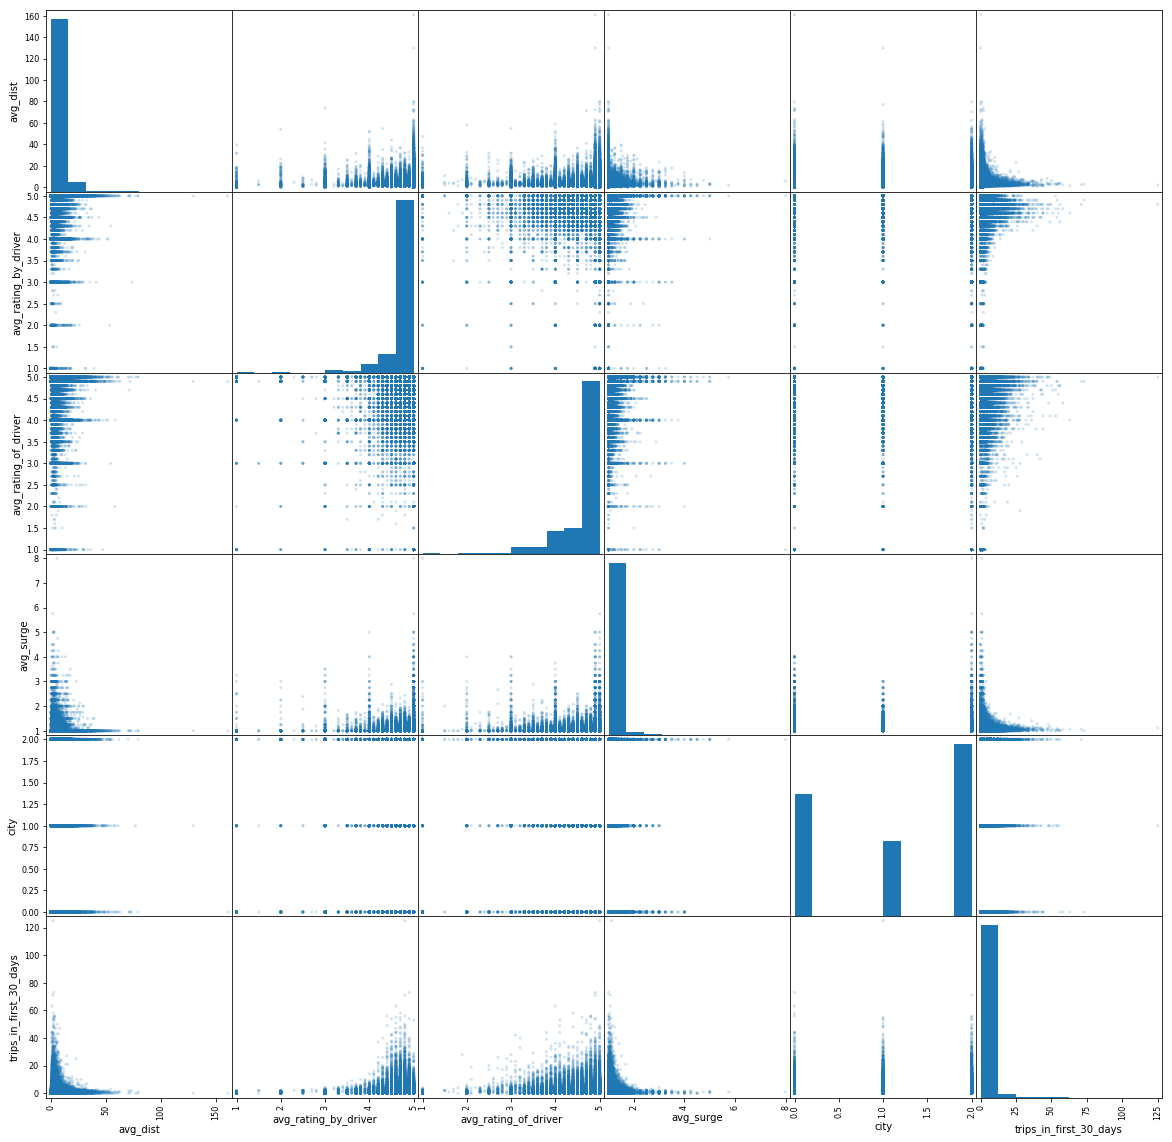

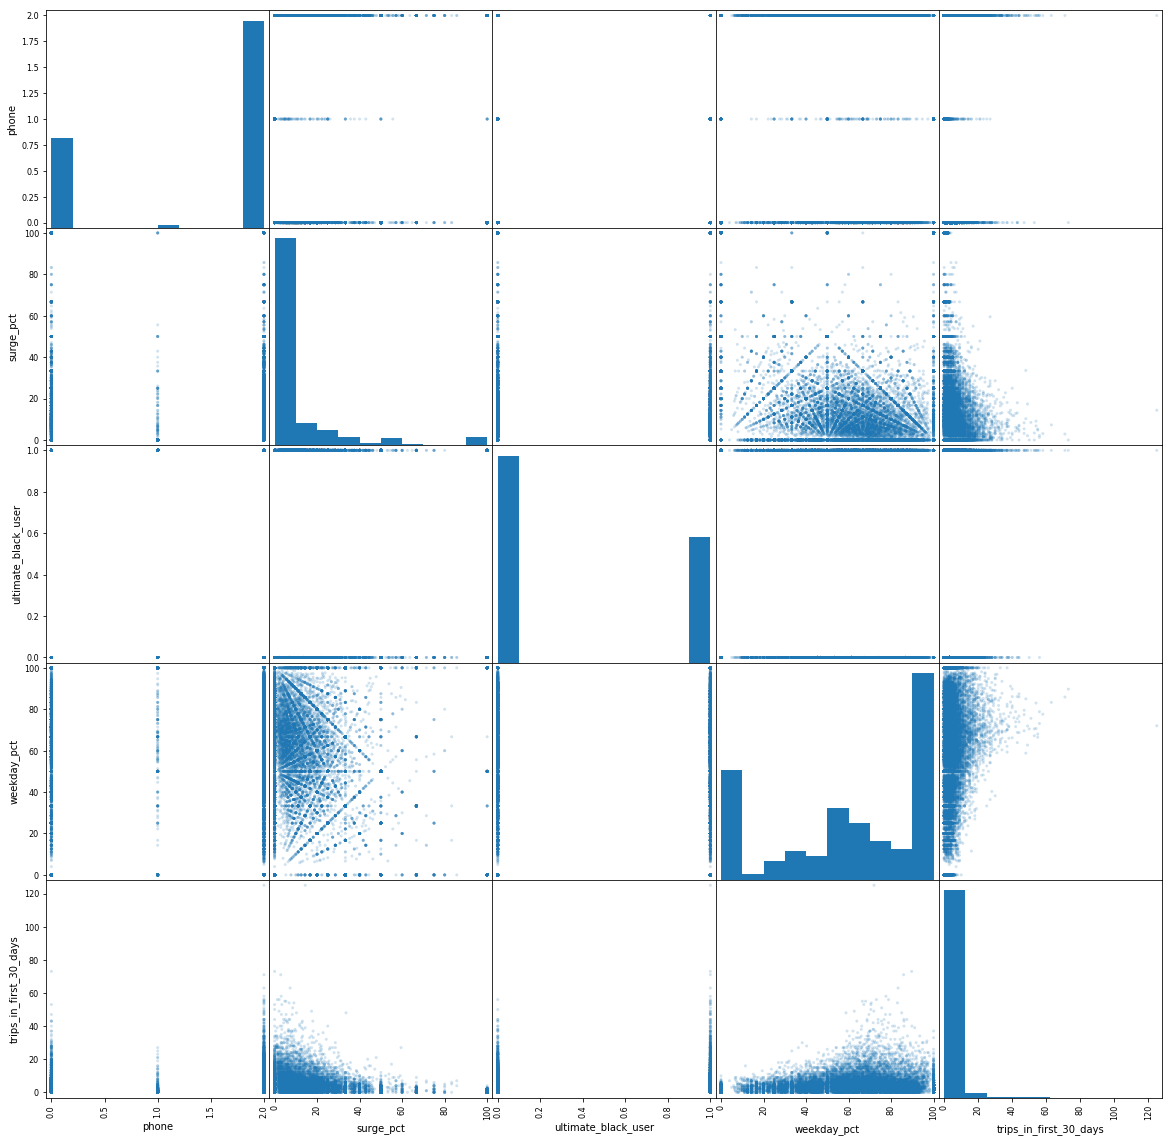

In [53]:
# Comparing the trend of the trips taken to the other features
test1 = ultimate_challange.iloc[:, np.r_[1:6,0]]
scatter_matrix(test1, alpha=0.2, figsize=(20, 20), diagonal='hist');

test2 = ultimate_challange.iloc[:, np.r_[6:10,0]]
scatter_matrix(test2, alpha=0.2, figsize=(20, 20), diagonal='hist');

The distribution of the features seem to be not normally distributed, but was appeared to be skewed either way except the weekday_pct feature (which is leaned to symmetrical). This can tell us that the data might have some outliers.

In [54]:
## Removing outliers using standard deviation

ult_outlier = []
for e in ultimate_challange.columns:
    v = ultimate_challange[e].values
    ult_mean = np.mean(v)
    ult_std = np.std(v)
    H = [y for y in v if (y > ult_mean - 3 * ult_std)]
    ult_remove= [y for y in H  if (y < ult_mean + 3 * ult_std)]
    ult_outlier.append(ult_remove)

## Deleting the rows with NaN
clean_ult= pd.DataFrame(ult_outlier).T
final = clean_ult.dropna(axis=0, how='any')
final.columns =  ultimate_challange.columns
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48529 entries, 0 to 48528
Data columns (total 10 columns):
trips_in_first_30_days    48529 non-null float64
avg_dist                  48529 non-null float64
avg_rating_by_driver      48529 non-null float64
avg_rating_of_driver      48529 non-null float64
avg_surge                 48529 non-null float64
city                      48529 non-null float64
phone                     48529 non-null float64
surge_pct                 48529 non-null float64
ultimate_black_user       48529 non-null float64
weekday_pct               48529 non-null float64
dtypes: float64(10)
memory usage: 4.1 MB


### What fraction of the observed users were retained

In [55]:
## Last date the data was pulled on
last_trip =ult['last_trip_date']
last_trip = pd.DataFrame(last_trip.sort_values())
last_trip.tail()

,last_trip_date
45126,2014-07-01
38651,2014-07-01
14473,2014-07-01
22735,2014-07-01
45357,2014-07-01


In [56]:
## retained users from June 01,2014
ret =ult[ult['last_trip_date'] >= '2014-06-01']
nonret = ult[ult['last_trip_date'] < '2014-06-01']
frac =(len(ret)/len(ult)) * 100
print (' The percent of the retained users are =%0.3f'  % frac)

 The percent of the retained users are =37.608


## Building Prediction Model

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve,accuracy_score, confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn import tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz

! pip install pydotplus
! pip install graphviz
import pydotplus
import graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO 


In [58]:
## Let us add retain column, as our target variable
ultNew =ult.copy()
ultNew['retain'] = np.nan
ultNew.loc[ultNew['last_trip_date'] >= '2014-06-01','retain'] = 1
ultNew.loc[ultNew['last_trip_date'] < '2014-06-01','retain'] = 0

# Drop the two date columns, as they are no more needed for our predicition
ultNew.drop('last_trip_date', axis=1, inplace =True)
ultNew.drop('signup_date', axis=1, inplace =True)
ultNew.head()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retain
0,3.67,5.0,4.7,1.10,King's Landing,iPhone,15.4,4,True,46.2,1.0
1,8.26,5.0,5.0,1.00,Astapor,Android,0.0,0,False,50.0,0.0
2,0.77,5.0,4.3,1.00,Astapor,iPhone,0.0,3,False,100.0,0.0
3,2.36,4.9,4.6,1.14,King's Landing,iPhone,20.0,9,True,80.0,1.0
4,3.13,4.9,4.4,1.19,Winterfell,Android,11.8,14,False,82.4,0.0


In [59]:
## Converting the categorical columns to numerical
ult_numeric =pd.get_dummies(ultNew, columns=['city','phone','ultimate_black_user'])
ult_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
avg_dist                     50000 non-null float64
avg_rating_by_driver         49799 non-null float64
avg_rating_of_driver         41878 non-null float64
avg_surge                    50000 non-null float64
surge_pct                    50000 non-null float64
trips_in_first_30_days       50000 non-null int64
weekday_pct                  50000 non-null float64
retain                       50000 non-null float64
city_Astapor                 50000 non-null uint8
city_King's Landing          50000 non-null uint8
city_Winterfell              50000 non-null uint8
phone_Android                50000 non-null uint8
phone_iPhone                 50000 non-null uint8
ultimate_black_user_False    50000 non-null uint8
ultimate_black_user_True     50000 non-null uint8
dtypes: float64(7), int64(1), uint8(7)
memory usage: 3.4 MB


In [60]:
## Cleaning NaN values
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp = imp.fit(ult_numeric.values)

# Impute our data, then train
ultImp = imp.transform(ult_numeric.values)
ultImp = pd.DataFrame(ultImp)

# Renaming the columns
ultImp.columns = ult_numeric.columns

In [61]:
# Moving retain to the front columns
c=list(ultImp)
c.insert(0, c.pop(c.index('retain')))

final =ultImp.ix[:,c]
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
retain                       50000 non-null float64
avg_dist                     50000 non-null float64
avg_rating_by_driver         50000 non-null float64
avg_rating_of_driver         50000 non-null float64
avg_surge                    50000 non-null float64
surge_pct                    50000 non-null float64
trips_in_first_30_days       50000 non-null float64
weekday_pct                  50000 non-null float64
city_Astapor                 50000 non-null float64
city_King's Landing          50000 non-null float64
city_Winterfell              50000 non-null float64
phone_Android                50000 non-null float64
phone_iPhone                 50000 non-null float64
ultimate_black_user_False    50000 non-null float64
ultimate_black_user_True     50000 non-null float64
dtypes: float64(15)
memory usage: 5.7 MB


C:\Users\benbahtin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """


In [62]:
# Separating the predictors and the target variables
X=final.values[:,1:15]
y=final.values[:,0]

# Standarizing the dataset
X_scaled = preprocessing.scale(X)
best=pd.DataFrame(X_scaled,y)

In [63]:
# Applying Correlation matrix to see the relationships between the response and feature variables

model = sm.OLS(y, X_scaled).fit()
predictions = model.predict(X_scaled)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     565.2
Date:                Thu, 25 Jan 2018   Prob (F-statistic):               0.00
Time:                        07:29:30   Log-Likelihood:                -43317.
No. Observations:               50000   AIC:                         8.666e+04
Df Residuals:                   49988   BIC:                         8.676e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0359      0.003    -13.605      0.000      -0.041      -0.031
x2            -0.0132      0.003     -5.066      0.000      -0.018      -0.008
x3            -0.0151      0.003     -5.796      0.000      -0.020      -0.010
x4            -0.0087      0.004     -2.041      0.041      -0.017      -0.000
x5             0.0154      0.004      3.584      0.000       0.007       0.024
x6             0.0758      0.003     28.792      0.000       0.071       0.081
x7            -0.0012      0.003     -0.462      0.644      -0.006       0.004
x8            -0.0595      0.002    -35.149      0.000      -0.063      -0.056
x9             0.0899      0.002     46.401      0.000       0.086       0.094
x10           -0.0164      0.002    -10.314      0.000      -0.019      -0.013
x11           -0.0343      0.013     -2.547      0.011      -0.061      -0.008
x12            0.0565      0.013      4.200      0.000       0.030       0.083
x13           -0.0417      0.001    -31.809      0.000      -0.044      -0.039
x14            0.0417      0.001     31.809      0.000       0.039       0.044
==============================================================================
Omnibus:                    15188.961   Durbin-Watson:                   1.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3691.241
Skew:                           0.419   Prob(JB):                         0.00
Kurtosis:                       1.966   Cond. No.                     4.87e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.69e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

As it can be observed in the summary,  the P-value for most of the predictors is less than the confidence level of 0.05, and this indicates that there is a statistically significant relationship between the predictors and the response variable. The only variable which yielded higher P-value was the weekday_pct  variable. However, the R2 resulted to a much lower value which indicates that the linear regression line did not approximate the real points well. Therefore, we should use algorithms other than linear regression for our analysis.

A decision tree algorithm will be utilized in my analysis,for (1) it is easy to undestand and no need to normalize the dataset; (2) it can easily handle irrelevant attributes through information gain; (3) it is robust against skewed distributions; (4) it can explain the non-linearity in the dataset in an intuitive manner.

In [64]:
## Split the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.3, random_state = 100)

# The number of observations in the training and testing datasets

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(35000, 14) (35000,)
(15000, 14) (15000,)


In [65]:
# Building the model and make prediction
model = DecisionTreeClassifier(max_depth = 5)
dec_mod = model.fit(X_train, y_train)
decision_pred =dec_mod.predict(X_test)

# Evaluating the model
print( ' The test accuracy of the model =%0.3f\n Confusion Matrix:\n' % accuracy_score(y_test, decision_pred), confusion_matrix(y_test, decision_pred))

# fpr, tpr, thresholds = roc_curve(y, scores)
# auc(fpr, tpr)

 The test accuracy of the model =0.753
 Confusion Matrix:
 [[8194 1172]
 [2532 3102]]


In [ ]:
final.columns[1:]

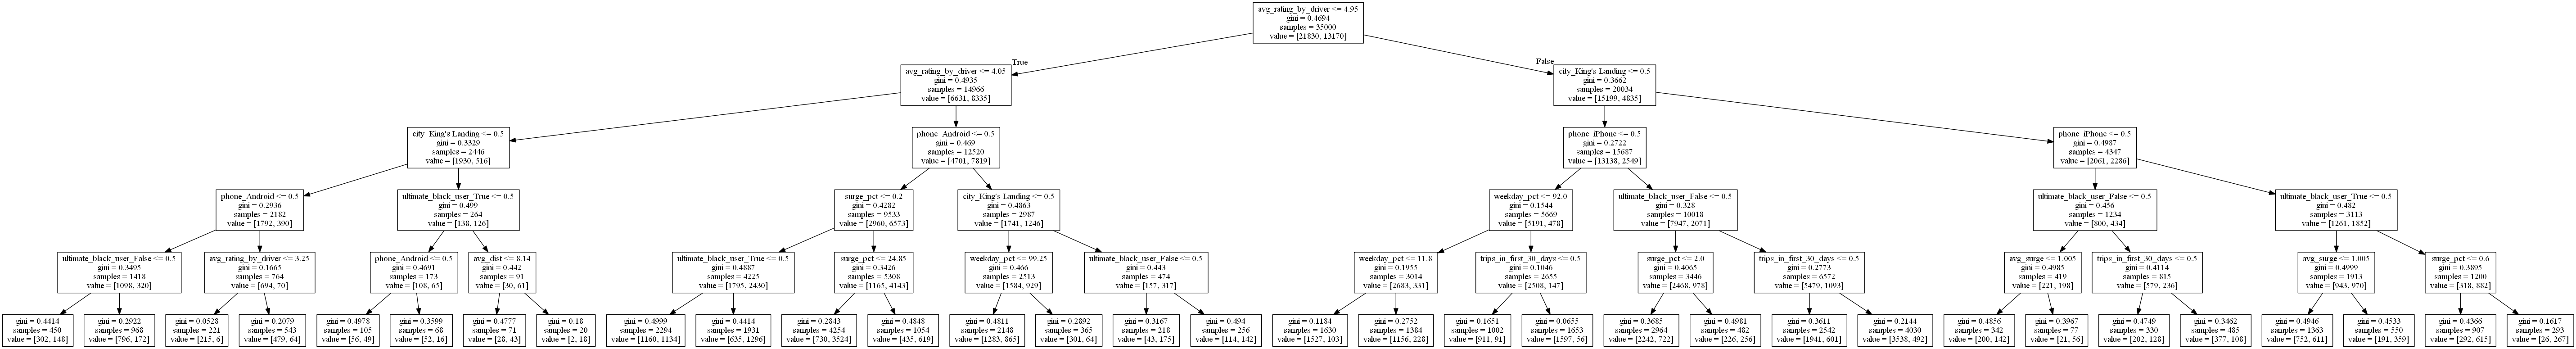

In [73]:
# Exporting the model results to file
dotfile = StringIO()
tree.export_graphviz(model, out_file=dotfile, feature_names =final.columns[1:])
graph=pydotplus.graph_from_dot_data(dotfile.getvalue())

# Saving the tree in pdf
graph.write_pdf("retain.pdf")

# Displaying the tree
Image(graph.create_png())

The test accuracy is yielded to 75.3 %, which shows that the model is appeared to perform well. The accuracy might have been better if we had optimized the model by applying cross validation.

In [72]:
# Discovering importance of each feature in the model
feat_imp = pd.DataFrame(dec_mod.feature_importances_).T
feat_imp.columns = final.columns[1:]
feat_imp = feat_imp.T
feat_imp1 = feat_imp.rename(index=str, columns ={0:'Feature Importance Rate'})
feat_imp1.sort_values(by='Feature Importance Rate')

,Feature Importance Rate
avg_rating_of_driver,0.000000
city_Astapor,0.000000
city_Winterfell,0.000000
avg_dist,0.000563
avg_surge,0.009367
trips_in_first_30_days,0.011557
weekday_pct,0.011669
ultimate_black_user_False,0.022788
ultimate_black_user_True,0.031750
phone_iPhone,0.044343


The above table shows the importance of each predictive features in the model. The avg_rating_by_driver	 and city_King's Landing seems to be the most importance predictive features followed by surge_pct and phone_Android users. This model may be helpful to have an understanding on the pattern of the retained customers; however this should be taken as a preliminary analysis that should be bolstered by further research and deeper analysis.

As a recommendation, more focus should be done on the features which are most valued by the model [avg_rating_by_driver	, city_King's Landing, phone_Android users and surge_pct]. Those features were most informative than the others. Based on the tree diagram: 

<li> __avg_rating_by_driver__ :  The riders with the avg_rating_by_driver of  less than or equal to 4.95 seem to retain.
<li> __city_King's Landing__:  more riders from this city_King's Landing tend not to retain.
<li> __surge_pct__: more  riders with less than or equal to 25% of trips taken with surge multiplier > 1 were tend to retain. Also, the ones with less than or equal to 0.2% did seem to retain